# Kernel method

```{warning}
This book is under construction.
```

```{admonition} Tip
:class: tip
Every page with code can be downloaded and run as a Jupyter notebook--just click <i class="fas fa-download"></i> at the top of the page and select '.ipynb'.

Most pages with code can be run in Google Colab --just click <i class="fas fa-rocket"></i> at the top of the page and select 'Colab'.
```

## Motivating Support Vector Machines

Consider the simple case of a classification task, 
in which the two classes of points are well separated:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns
sns.set()

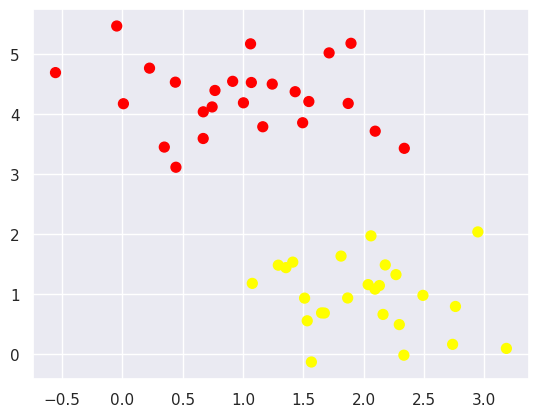

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

A linear discriminative classifier would attempt 
to draw a straight line separating the two sets of data, 
and thereby create a model for classification. 
For two-dimensional data like that shown here, 
this is a task we could do by hand. But immediately 
we see a problem: there is more than one possible 
dividing line that can 
perfectly discriminate between the two classes!

We can draw them as follows:

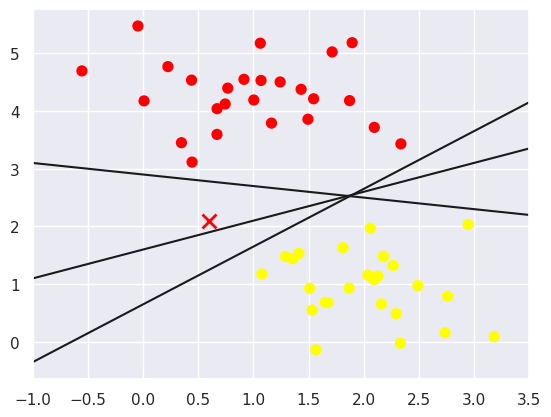

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

These are three very different separators which, 
nevertheless, perfectly discriminate between these 
samples. Depending on which you choose, a new data point 
(e.g., the one marked by the "X" in this plot) will be 
assigned a different label! Evidently our simple intuition 
of "drawing a line between classes" is not enough, 
and we need to think a bit deeper.


## Support Vector Machines: Maximizing the _Margin_

Support vector machines offer one way to improve on this. 
The intuition is this: rather than simply drawing a 
zero-width line between the classes, we can draw around each 
line a margin of some width, up to the nearest point. 
Here is an example of how this might look:

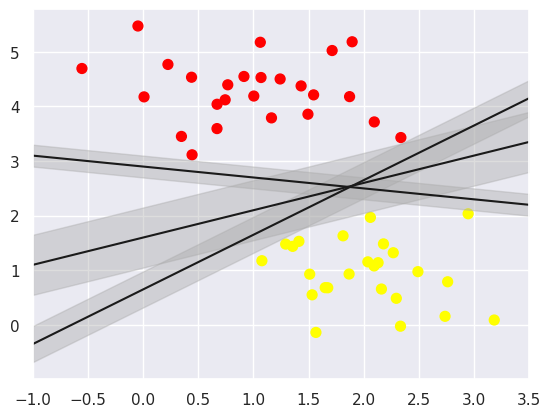

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

In support vector machines, the line that maximizes this margin 
is the one we will choose as the optimal model. 
Support vector machines are an example of such a maximum margin estimator.


## Fitting a support vector machine



```{figure} ../../images/svm/svm2d.png
---
name: 'SVM for Linear classification : 2D case'
width: 90%
---
SVM for Linear classification : 2D case. [source](https://online.stat.psu.edu/stat555/node/102/)
```

```{figure} ../../images/svm/svm3d.gif
---
name: 'SVM for Linear classification : 3D case'
width: 90%
---
SVM for Linear classification : 3D case. [source](https://www.youtube.com/watch?v=3liCbRZPrZA)
```


Let's see the result of an actual fit to this data: 
we will use Scikit-learn's support vector classifier to 
train an SVM model on this data. For the time being, 
we will use a linear kernel and set the ```C``` parameter to a very large number 
(we'll discuss the meaning of these in more depth momentarily).

In [5]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y);

To better visualize what's happening here, 
let's create a quick convenience function that 
will plot SVM decision boundaries for us:

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

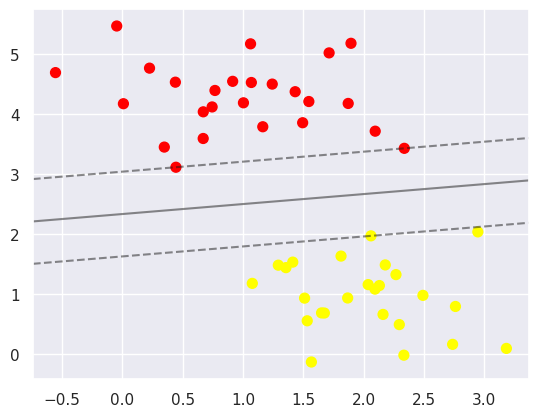

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

This is the dividing line that maximizes 
the margin between the two sets of points. 
Notice that a few of the training points just 
touch the margin: they are indicated by the 
black circles in this figure. These points are 
the pivotal elements of this fit, and are known as 
the support vectors, and give the algorithm its name. 
In Scikit-Learn, the identity of these points are 
stored in the ```support_vectors_``` attribute of the classifier:

In [8]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

A key to this classifier's success is that for the fit, only the position of the support vectors matter; 
any points further from the margin which are on the correct side 
do not modify the fit! Technically, this is because these points do not contribute to the loss function 
used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, 
if we plot the model learned from the 
first 60 points and first 120 points of this dataset:

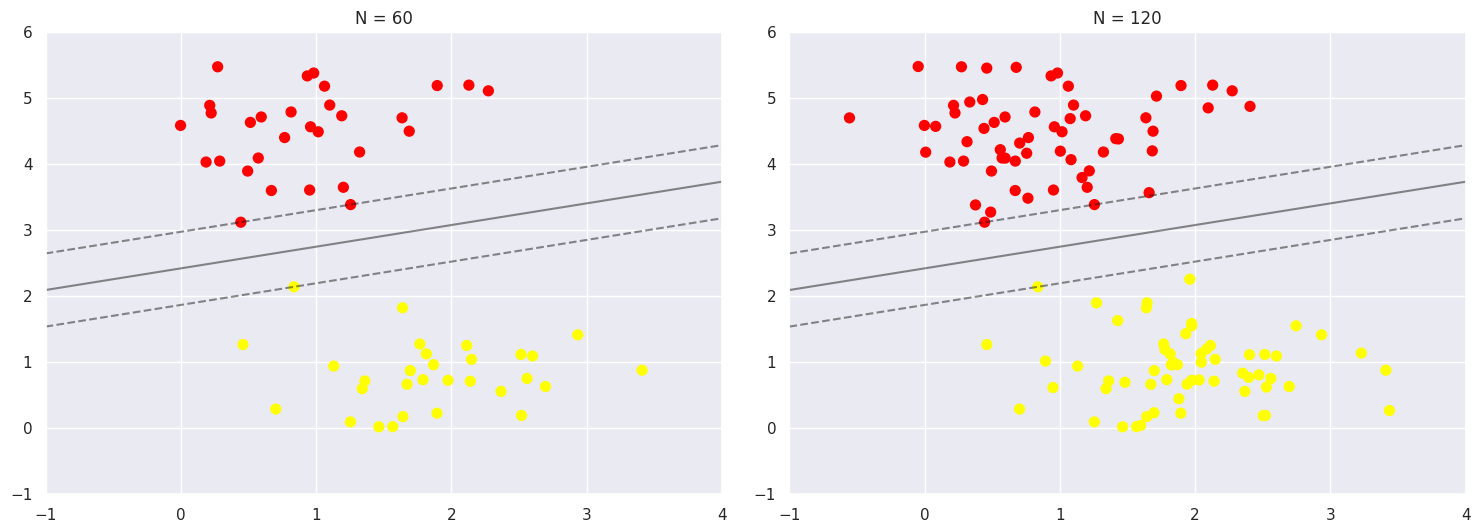

In [9]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

In the left panel, we see the model and the support vectors for 60 training points. 
In the right panel, we have doubled the number of training points, 
but the model has not changed: the three support vectors from the left panel are still 
the support vectors from the right panel. This insensitivity to the exact behavior of 
distant points is one of the strengths of the SVM model.

If you are running this notebook live, 
you can use IPython's interactive widgets to view this feature of the SVM model interactively:

In [10]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 200), value=10), Output()), _dom_classes=('widget…

## Beyond linear boundaries: Kernel SVM


```{figure} ../../images/svm/svm1.gif
---
name: Kernel SVM visualization
width: 90%
---
Kernel SVM visualization (with a polynomial kernel). [source](https://www.youtube.com/embed/3liCbRZPrZA)
```



Where SVM becomes extremely powerful is when it is combined with _kernels_.
The main idea is to project the data into higher-dimensional space defined by 
polynomials and Gaussian basis functions, 
and thereby were able to fit for nonlinear relationships with a linear classifier.

To motivate the need for kernels, let's look at some data that is not linearly separable:

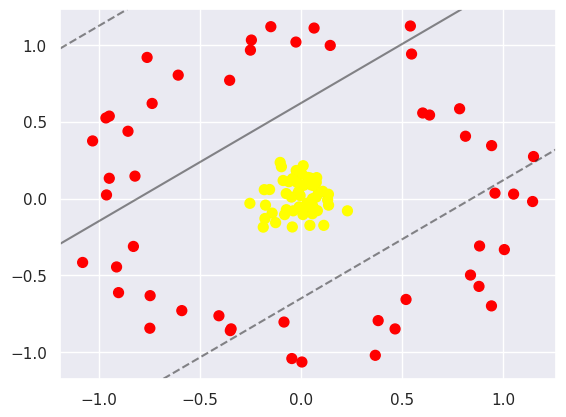

In [11]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

It is clear that no linear discrimination will ever be able to separate this data. 
But we can  project the data into a 
higher dimension such that a linear separator would be 
sufficient. For example, one simple projection we could 
use would be to compute a radial basis function centered on the middle clump:

In [12]:
r = np.exp(-(X ** 2).sum(1))

We can visualize this extra data dimension using a three-dimensional 
plot. If you are running this notebook live, 
you will be able to use the sliders to rotate the plot:

In [13]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180),
         X=fixed(X), y=fixed(y));

interactive(children=(Dropdown(description='elev', options=(-90, 90), value=-90), IntSlider(value=30, descript…

We can see that with this additional dimension, 
the data becomes trivially linearly separable, 
by drawing a separating plane at, say, $r=0.7$.

Here we had to choose and carefully tune our projection: 
if we had not centered our radial basis function in the right location, 
we would not have seen such clean, linearly separable results. 
In general, the need to make such a choice is a problem: 
we would like to somehow automatically find the best basis functions to use.

One strategy to this end is to compute a basis function centered at every 
point in the dataset, and let the SVM algorithm sift through the results. 
This type of basis function transformation is known as a _kernel transformation_, 
as it is based on a similarity relationship (or kernel) between each pair of points.

A potential problem with this strategy—projecting $N$ points 
into $N$ dimensions—is that it might become very computationally 
intensive as $N$ grows large. However, because of a neat little procedure known 
as the _kernel trick_, a fit on kernel-transformed data can be done implicitly—that is, 
without ever building the full $N$-dimensional representation of the kernel projection! 
This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

In Scikit-Learn, we can apply kernelized 
SVM simply by changing our linear kernel 
to an RBF (radial basis function) kernel, 
using the ```kernel``` model hyperparameter:

In [14]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y);

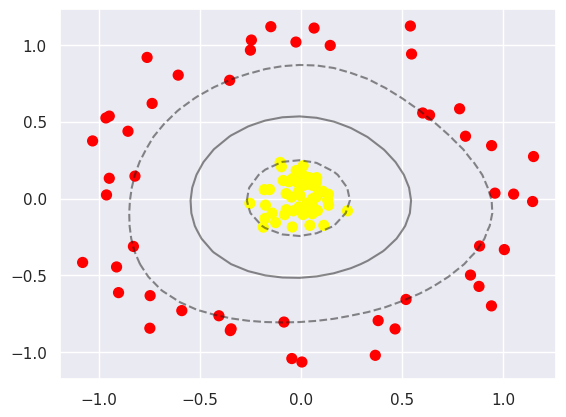

In [15]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

Using this kernelized support vector machine, we learn a suitable 
nonlinear decision boundary. 
This kernel transformation strategy is used often in machine learning 
to turn fast linear methods into fast nonlinear methods, especially for 
models in which the kernel trick can be used.



## Hinge loss

An alternative to cross-entropy for binary 
classification problems is the hinge loss function.
It is primarily developed for use with 
Support Vector Machine (SVM) models.

It is intended for use with binary 
classification where the target values are in the set {-1, 1}.

## RBF Kernel

<div class="yt-container">
   <iframe src="https://www.youtube.com/embed/NYwVM6_EuxQ" allowfullscreen></iframe>
</div>

## Support Vector Regression (SVR)


With SVR, we are basically 
trying to decide a decision boundary at $e$ distance 
from the original hyper plane such that data points 
closest to the hyper plane or the support vectors are 
within that boundary line.


```{figure} ../../images/svm/svr1.jpeg
---
name: support vector regression
width: 90%
---
An illustration of support vector regression
```


## SVM v.s. logistic regression

- SVM works well with unstructured and semi-structured data like text and images while logistic regression works with already identified independent variables.
- SVM is based on geometrical properties of the data while logistic regression is based on statistical approaches.
- The risk of overfitting is less in SVM, while logistic regression is vulnerable to overfitting.
- LR gives calibrated probabilities that can be interpreted as confidence in a decision.
- LR gives us an unconstrained, smooth objective. 
- LR can be (straightforwardly) used within Bayesian models.
- SVMs don’t penalize examples for which the correct decision is made with sufficient confidence. This may be good for generalization.
- SVMs have a nice dual form, giving sparse solutions when using the kernel trick (better scalability)

```{seealso}
https://www.geeksforgeeks.org/differentiate-between-support-vector-machine-and-logistic-regression/
```

## SVR v.s. linear regression

- One Advantage of SVR over OLSE linear regression is 
SVR can minimize overfitting problem.
- SVR allows non linear fitting problems as well (based on the kernel trick and the representation of the solution/model in the dual rather than in the primal),
while Linear Regression is only for simple linear regression with straight line (may contain any number of features in both cases).

## Support Vector Machine Summary
We have seen here a brief intuitive introduction to 
the principals behind support vector machines. 
These methods are a powerful classification method for a number of reasons:
- Their dependence on relatively few support vectors means that they are very compact models, and take up very little memory.
- Once the model is trained, the prediction phase is very fast.
- Because they are affected only by points near the margin, they work well with high-dimensional data—even data with more dimensions than samples, which is a challenging regime for other algorithms.
- Their integration with kernel methods makes them very versatile, able to adapt to many types of data.

However, SVMs have several disadvantages as well:
- The scaling with the number of samples N is $O[N^3]$ at worst, 
or $O[N^2]$ for efficient implementations. For large numbers of training samples, this computational cost can be prohibitive.
- The results are strongly dependent on a suitable choice for the softening parameter $C$. 
This must be carefully chosen via cross-validation, which can be expensive as datasets grow in size.
- The results do not have a direct probabilistic interpretation. This can be estimated via an internal 
cross-validation (see the ```probability``` parameter of ```SVC```), but this extra estimation is costly.

## [Optional] Let's dive into the math of SVM ...

<div class="yt-container">
   <iframe src="https://www.youtube.com/embed/05VABNfa1ds" allowfullscreen></iframe>
</div>

## Acknowledgement

[jakevdp](https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html), which is licenced under CC-by licence.


## Kernel PCA

https://rishi-advani.com/random-projections/notebooks/html/Kernel_PCA.html

<div hidden>

https://slazebni.cs.illinois.edu/spring21/lec03_linear.pdf

https://slazebni.cs.illinois.edu/spring21/lec05_nonlinear_classifiers.pdf

</div>